# Machine Learning 1

## About this course
Some machine learning courses can leave you confused by the enormous range of techniques shown and can make it difficult to have a practical understanding of how to apply them.

The good news is that modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

- **Ensembles of decision trees** (i.e. Random Forests and Gradient Boosting Machines), mainly for **structured data** (such as you might find in a database table at most companies)
- **Multi-layered neural networks learnt with Stochastic Gradient Descent** (SGD) (i.e. shallow and/or deep learning), mainly for **unstructured data** (such as audio, vision, and natural language)

### The lessons
In this course we'll be learning about:
- **Random Forests** 
- **Stochastic Gradient Descent**.
- **Gradient Boosting** 
- **Deep Learning**

### The dataset
We will be teaching the course using the [Blue Book for Bulldozers Kaggle Competition](https://www.kaggle.com/c/bluebook-for-bulldozers): 
- "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations."


# Google Colab
The notebooks of this series are to be runned in Google Colab using the **free GPU**.

Let's confirm that the GPU is enabled ([source](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=3IEVK-KFxi5Z)). If not, simply select "GPU" in the Notebook **Runtime** Settings (**change runtime type**).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


The notebooks have been adapted to run on little GPU ram (**564MB**), because that is what is available using Colab where I live.

To  check how much GPU ram you have available, use the code below ([source](https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available)) and check for 'GPU RAM Free''. 

In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /content/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /content/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 11.9 GB  | Proc size: 1.0 GB
GPU RAM Free: 564MB | Used: 10875MB | Util  95% | Total 11439MB


## Install fastai library

In [3]:
!pip install git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-s4zwfhbw
    100% |████████████████████████████████| 1.5MB 8.5MB/s 
    100% |████████████████████████████████| 112kB 10.6MB/s 
    100% |████████████████████████████████| 184kB 10.2MB/s 
    100% |████████████████████████████████| 3.6MB 9.7MB/s 
    0% |▏                               | 3.0MB 30.4MB/s eta 0:00:17

    100% |████████████████████████████████| 496.4MB 36kB/s 
    100% |████████████████████████████████| 51kB 12.8MB/s 
    100% |████████████████████████████████| 61kB 15.2MB/s 
    100% |████████████████████████████████| 51kB 13.9MB/s 
    100% |████████████████████████████████| 2.2MB 3.1MB/s 
    100% |████████████████████████████████| 13.7MB 1.6MB/s 
    100% |████████████████████████████████| 92kB 23.5MB/s 
    100% |████████████████████████████████| 112kB 23.9MB/s 


    100% |████████████████████████████████| 71kB 11.9MB/s 
    100% |████████████████████████████████| 901kB 1.9MB/s 
    100% |████████████████████████████████| 81kB 12.6MB/s 
    100% |████████████████████████████████| 4.4MB 2.4MB/s 
    100% |████████████████████████████████| 1.5MB 3.6MB/s 
    100% |████████████████████████████████| 15.8MB 1.7MB/s 
    100% |████████████████████████████████| 71kB 12.8MB/s 


  Running setup.py bdist_wheel for fastai ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-g4qx1cb3/wheels/cf/46/39/b2d08762125ed2376861976ab2c4ac30c029b86e375735d9b8
  Running setup.py bdist_wheel for bcolz ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
  Running setup.py bdist_wheel for feather-format ... - done
  Stored in directory: /content/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Running setup.py bdist_wheel for torchtext ... - \ done
  Stored in directory: /content/.cache/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e5627ccc99543abded97204
  Running setup.py bdist_wheel for pyproj ... - \ | / - 

 / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/89/77/ec/a537585d1022dafde0317dd19d33c4a30d4ee61e19f25ebd8e
  Running setup.py bdist_wheel for munch ... - done
  Stored in directory: /content/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
  Running setup.py bdist_wheel for click-plugins ... - done
  Stored in directory: /content/.cache/pip/wheels/bc/86/aa/7680e54728998edc1e966a20249b920e582012ed6bdd3815c4
Successfully built fastai bcolz feather-format torchtext pyproj munch click-plugins
plotnine 0.4.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0

# Lesson 1: Introduction to Random Forests

It is recommended to [watch the lesson first](https://youtu.be/CzdWqFTmn0Y), then follow the notebook.

## Imports

I will be importing things **as I need them**, because I'm not that experienced and it **helps me to learn** where do things come from.

## The data

For [this competition](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you are **predicting the sale price of bulldozers sold at auctions**.

The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- **SalesID**: the uniue identifier of the sale
- **MachineID**: the unique identifier of a machine. A machine can be sold multiple times
- **saleprice**: what the machine sold for at auction (only provided in train.csv)
- **saledate**: the date of the sale

### Importing the data

We'll be importing the data from a gitlab repository ([source](https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9)).

In [4]:
! git clone https://gitlab.com/ailobe/data.git

Cloning into 'data'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (11/11), done.


In [5]:
# list all the files in the current directory
! ls

data  datalab


### Exploring the data

In [0]:
# import pandas
import pandas as pd

# set the path to read Train.csv
path = 'data/bulldozers/Train.csv'

# read the data into a pandas DataFrame
df_raw = pd.read_csv(path,
                     low_memory=False, # use as much memory as necessary to figure out dtypes
                     parse_dates=["saledate"]) # read saledate column as datetime dtype

In [7]:
# dimensions (rows, columns)
df_raw.shape

(401125, 53)

It's a **large dataset**.

In [8]:
# print 5 first rows
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pandas switchs to **truncate view** when there are too many rows and columns, but we can change the display options if we want to see all of them.

In [0]:
# create a function that displays up to a thousand rows and columns of a dataframe
# pd.option_context(*args) is a context manager to temporarily set options in the `with` statement context
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [10]:
# show the tail (last 5 rows)
# for readability, we use the .T attribute (equal to the .transpose() method) to transpose the df so we have to scroll down instead of sideways.
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [11]:
# generate descriptive statistics of all columns (including object columns). View transposed for readability.
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Initial processing


#### SalePrice

- SalePrice is the **dependent variable**, the target.
- Kaggle tells us that the evaluation metric for this competition is the **RMSLE** (root mean squared log error) between the actual and predicted auction prices.
- Therefore we take the **log of the prices**, so that RMSE will give us what we need.

In [12]:
#import numpy
import numpy as np

# replacing SalePrice column values with the calculated natural logarithm of SalePrice values.
df_raw['SalePrice'] = np.log(df_raw.SalePrice)

# show head of column
df_raw.SalePrice.head()

0    11.097410
1    10.950807
2     9.210340
3    10.558414
4     9.305651
Name: SalePrice, dtype: float64

We need to **split** the **dependent variable** from the dataset.
- Later on, we'll use a method from the **fastai library** , **`proc_df`**,  to do just that and more.
- We show some alternative code below to illustrate the process.

In [0]:
# DataFrame with a column removed
dataset = df_raw.drop('SalePrice', axis=1)

# select a Series from the DataFrame
dependent = df_raw.SalePrice

#### SaleDate

We already know that one of the features is a date and we've explicitly told pandas to read it as  **datetime dtype**.

In [14]:
# prints first 5 rows of the column
df_raw.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

 **What's in a date is one of the more important pieces of feaute engineering you can do** (i.e. Was it a holiday? Was it raining?).

- We'll use a method from the **fastai library**, **`add_datepart`**, that extracts particular date fields from a complete datetime for the purpose of constructing categoricals. 
- You should always consider this **feature extraction** step when working with date-time dtypes. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [0]:
# import add_datepart
from fastai.structured import add_datepart

add_datepart(df_raw, 'saledate')

We can check the **source code** of a function  by typing its name and **??** (before or after the name).

In [0]:
add_datepart??

So `add_datepart` converts a column of a DataFramefrom a **datetime64 to many columns containing the information from the date** (changes occur inplace).

In [17]:
# column labels of the DataFrame.
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


There are a bunch of new columns. Let's take a look.

In [18]:
# acces the selected [rows, columns]. View transposed.
df_raw.loc[:,['saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end',
       'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start',
       'saleElapsed']].T

,0,1,2,3,4,5,6,7,8,9,...,401115,401116,401117,401118,401119,401120,401121,401122,401123,401124
saleYear,2006,2004,2004,2011,2009,2008,2004,2005,2009,2007,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
saleMonth,11,3,2,5,7,12,8,11,8,8,...,10,10,10,10,10,11,11,11,10,10
saleWeek,46,13,9,20,30,51,35,46,35,32,...,43,43,43,43,43,44,44,44,43,43
saleDay,16,26,26,19,23,18,26,17,27,9,...,25,25,25,25,25,2,2,2,25,25
saleDayofweek,3,4,3,3,3,3,3,3,3,3,...,1,1,1,1,1,2,2,2,1,1
saleDayofyear,320,86,57,139,204,353,239,321,239,221,...,298,298,298,298,298,306,306,306,298,298
saleIs_month_end,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
saleIs_month_start,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
saleIs_quarter_end,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
saleIs_quarter_start,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Categorical Data

As in most cases when dealing with datasets, this dataset contains a mix of **continuous** and **categorical** variables.
- We need all of them to be **numeric** so they can be used by the model.
- We must make the necessary changes (**feature engineering**).

In [19]:
# count dtypes in the dataframe
df_raw.dtypes.value_counts()

object     44
int64      12
bool        6
float64     3
dtype: int64

If we look at the numeric columns, we can se that **most of them** are not cotinuous but **categorical**.
- Even though it's not ideal that they stay that way, **random forest** works fine with it so there is **no problem** (we'll learn why).

In [20]:
# select numerical columns
df_raw.select_dtypes(['int64','float64']).head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,2011,5,20,19,3,139,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,2009,7,30,23,3,204,1248307200


Most of the **categorical variables are currently stored as strings** (objects).
- Apart from being inefficient, it doesn't provide the **numeric coding** required for our model.

- We'll use a method from the **fastai library** , **`train_cats`**,  to convert strings to pandas categories.

In [0]:
# import train_cats
from fastai.structured import train_cats


train_cats(df_raw)

We can again check the **source code** of the function for more information.

In [0]:
??train_cats

In [23]:
# examine all the data types
display_all(df_raw.dtypes)

SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

Indeed it has changed inplace all columns that contained **strings to category dtypes**.
- It doesn't make the DataFrame look different but behind the scenes all string are encoded with **integers mapped to the strings**.
- Let's look at UsageBand, our first category column.

In [24]:
# categories of this categorical
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [25]:
# encoded variables
df_raw.UsageBand.cat.codes.head()

0    1
1    1
2    0
3    0
4    2
dtype: int8

We can **specify the order** to use for categorical variables if we wish:

In [0]:
# sets the categories to the specified new_categories, ordered in place.
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Finally, to fit this data to a random forest, we would need to **replace the text categories with their numeric codes**.
- We'll use a method from the **fastai library** , **`proc_df`**,  to do just that and more.
- We show some alternative code below to illustrate the process.

In [27]:
# make a copy for demonstration purposes
df_codes = df_raw.copy()

# iterate through column name and column values and if column values are categories, replace them with their numeric code.
for name, column in df_codes.items():
  if column.dtype.name == 'category':
    df_codes[name] = column.cat.codes
    
# count dtypes in the dataframe
df_codes.dtypes.value_counts()

int8       40
int64      12
bool        6
int16       4
float64     3
dtype: int64

This is a **two step process** for being able to **fit categorical** variables to our model: first we convert **strings to categories**, then **categories to codes**/numbers.
- The result is that all variables are recoded in **only one column** using different integers for different categories, which is **useful for** columns with **lots of possible values**. 
- An **alternative** to this would be to **get dummy variables** for the categorical variables, but it would resolve it by recoding all the variables in **different columns** with **zeroes** and **ones**.

#### Missing Data

Handling missing data is important as **many** machine learning **algorithms do not support** data with **missing values** ([source](https://machinelearningmastery.com/handle-missing-data-python/)).

Typically, random forest methods/packages encourage **two ways** of handling missing values ([source](https://medium.com/airbnb-engineering/overcoming-missing-values-in-a-random-forest-classifier-7b1fc1fc03ba)): 
- **Drop data points** with missing values (not recommended)
- **Fill** in missing values with the **median** (for numerical values).

In [28]:
# display all columns with the percentage of missing values (NaN)
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

Pandas has handled all **missing values** in the **categories** automatically by encoding  them with a **minus one**.

In [29]:
# categories of this categorical
print(df_raw.Hydraulics.cat.categories)

# encoded variables
df_raw.Hydraulics.cat.codes.head(6)

Index(['2 Valve', '3 Valve', '4 Valve', 'Auxiliary', 'Base + 1 Function',
       'Base + 2 Function', 'Base + 3 Function', 'Base + 4 Function',
       'Base + 5 Function', 'Base + 6 Function', 'None or Unspecified',
       'Standard'],
      dtype='object')


0    0
1    0
2    3
3    0
4    3
5   -1
dtype: int8

For the **numerical data**, we need to **replace** the **missing values** with the **median** (also called median imputation).
- We'll use a method from the **fastai library** , **`proc_df`**,  to do just that and more.
- We show some alternative code below to illustrate the process.

In [30]:
# select numerical columns
num_col = df_raw.select_dtypes(include='number')

# display numerical columns with the percentage of missing values (NaN)
num_col.isnull().sum().sort_index()/len(df_raw)

MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
SalePrice                   0.000000
SalesID                     0.000000
YearMade                    0.000000
auctioneerID                0.050199
datasource                  0.000000
saleDay                     0.000000
saleDayofweek               0.000000
saleDayofyear               0.000000
saleElapsed                 0.000000
saleMonth                   0.000000
saleWeek                    0.000000
saleYear                    0.000000
dtype: float64

In [31]:
# make a copy for demonstration purposes
df_imputed = df_raw.copy()

# iterate through column name and column values and if column values are numerical, replace NA values with the column median.
for name, column in df_imputed.items():
  if column.dtype == np.number:
    df_imputed[name] = df_imputed[name].fillna(column.median())

# select numerical columns
num_col = df_imputed.select_dtypes(include='number')

# display numerical columns with the percentage of missing values (NaN)
num_col.isnull().sum().sort_index()/len(df_raw)

MachineHoursCurrentMeter    0.0
MachineID                   0.0
ModelID                     0.0
SalePrice                   0.0
SalesID                     0.0
YearMade                    0.0
auctioneerID                0.0
datasource                  0.0
saleDay                     0.0
saleDayofweek               0.0
saleDayofyear               0.0
saleElapsed                 0.0
saleMonth                   0.0
saleWeek                    0.0
saleYear                    0.0
dtype: float64

## Pre-processing

We'll use a method from the **fastai library** , **`proc_df`**,  to get the dataset ready for the random forest.
- We'll **replace categories** with their numeric codes.
- **Handle missing** continuous **values**.
- **Split the dependent variable** into a separate variable.

In [0]:
# import proc_df and the functions it depends on
from fastai.structured import numericalize, fix_missing, proc_df

X, y, nas_dict = proc_df(df_raw, 'SalePrice')

For more information, we can again check the **source code**:

In [0]:
??proc_df

The method **`fix_missing`** has returned `nas_dict`, which is a dictionary with the name of the columns that had missing data.
- From the function docstring: Fill missing data in a column of df with the median, and add a {name}_na column which specifies if the data was missing (boolean).
- Our model will **not be using it** but we can check it out.

In [34]:
nas_dict

{'MachineHoursCurrentMeter': 0.0, 'auctioneerID': 2.0}

So we know the columns MachineHoursCurrentMeter' and 'auctioneerID' had missing values and according to the docstring, `fix_missing` has added **new columns** which specifies if the data was missing. Let's see.'

In [35]:
# acces columns with names containing some strings
X.loc[:, X.columns.str.contains('MachineHoursCurrentMeter|auctioneerID')].head()

,auctioneerID,MachineHoursCurrentMeter,auctioneerID_na,MachineHoursCurrentMeter_na
0,3.0,68.0,False,False
1,3.0,4640.0,False,False
2,3.0,2838.0,False,False
3,3.0,3486.0,False,False
4,3.0,722.0,False,False


Anyhow, now the **dataset is ready** to be to be passed to a **random forest**.

# Lesson 2: Random Forests

It is recommended to [watch the lesson first](https://youtu.be/blyXCk4sgEg), then follow the notebook.
- If you start from this point, you need to run all the cells above by selecting "**Run before**" in the Notebook **Runtime** Settings.

## Imports

I will be importing things **as I need them**, because I'm not that experienced and it **helps me to learn** where do things come from.

## Base model

### Validation set

To **avoid  overfitting** , we'll split the dataset to have two **separate training and validation sets**.
- Since we are trying to predict new prices, we should pick the **latest samples** from our train set.
- We'll use the **same size as** the **Kaggle** validation set, so when we evaluate our model it gives us an estimation of how will it perform in the **public leaderboard**.

In [36]:
# set the path to read the Valid.csv
path = 'data/bulldozers/Valid.csv'

# dimensions of the dataframe (rows, columns)
pd.read_csv(path).shape

(11573, 52)

The set Kaggle used for creating the public leaderboard has roughtly **12,000 samples**, so that is the size we'll use for our validation set.

In [37]:
# create a function for splitting X and y into train and test sets of customizable sizes
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

# validation set size: 12000.
validation = 12000

# split point: length of dataset minus validation set size.
split_point = len(X)-validation

# split X
X_train, X_valid = split_vals(X, split_point)

# split y
y_train, y_valid = split_vals(y, split_point)

# dimensions (row, columns) of X, y and X_valid
X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

### Model evaluation

**RMSE**

Remember the evaluation metric that Kaggle is going to use for this competition is the Root Mean Squared Log Error (**RMSLE**) between the actual and predicted auction prices.
- Because we **already took the log** of the prices, we can use the Root Mean Squared Error (RMSE) instead.

The **RMSE** is an evaluation metric that expresses the **average error of the model predictions** by comparing the predicted values with the actual known values.
- The score can range from **0** (best score possible, never achieved in practice) to **∞**, so the **lower the score the better**.

**R Squared**

The coefficient of determination R^2 (**R squared**) is an evaluation metric for regression problems that essentially tells us **how good is our model** compared with **a model that just predicts the average** of the target (saleprice) all the time .
- The **best** possible score is **1**.
- The score of the **average** model is **0**.
- A **negative** score means the model is even **worse** than simply predicting the average of the target.

In [38]:
# create a function that takes the RMSE
def rmse(pred,known): return np.sqrt(((pred-known)**2).mean())

# create a function that returns a list of 4 scores: the RMSE and the R Squared for each the training and the validation set
def print_scores(model):
    scores = [rmse(model.predict(X_train), y_train), rmse(model.predict(X_valid), y_valid),
                model.score(X_train, y_train), model.score(X_valid, y_valid)]
    print(scores)

# import the class
from sklearn.ensemble import RandomForestRegressor

# instantiate the model 
rf = RandomForestRegressor(n_jobs=-1) # n_jobs is a performance parameter. -1 is to paralelize the computations across the number of CPU cores.

# fit the model with data and calculate the running time
%time rf.fit(X_train, y_train)

# print a list of 4 scores:
# [RMSE of the training set, RMSE of the validation set, R Squared of the training set, R Squared of the validation set]
print_scores(rf)

CPU times: user 1min 24s, sys: 356 ms, total: 1min 24s
Wall time: 43.5 s
[0.09054847140502638, 0.24884544330546157, 0.9828644885141301, 0.8894121641376656]


These four scores allows us to evaluate the accuracy of our model.
- An **R Squared** of the validation set in the **high-80's** tells us that our model is significantly **better** than simply **predicting the average** price.
- The large difference of the **RMSLE** of the training (**0.09**) and the validation sets (**0.25**) tells us that we're **over-fitting badly**, because the average error of the model predictions are much greater when dealing with data it hasn't been trained with.

## Speeding things up

In order to make the model development process more **interactive**, we need to make sure that the model runs in a reasonable time to be able to **make some changes and see the results fast**.
- We''ll use the paramater **`subset`** from **`proc_df`** that takes a random subset of the selected size from the dataframe.
- We'll randomly sample **32,000** from the original 401,125 rows.
- We'll use the **same validation set** as before.
- To make sure our training set doesn't overlap with the dates of the validation set we'll **split again the subset** we've taken and **discard the last 12,000** rows.

In [0]:
# randomly sample 32000 thousand rows
X_subset, y_subset, nas_dict = proc_df(df_raw, 'SalePrice', subset=32000)

# split the train subset and discard the last 12000 rows: X_train [:20000], _ [20000:].
X_train, _ = split_vals(X_subset, 20000)

# split the target subset and discard the last 12000 rows: X_train [:20000], _ [20000:].
y_train, _ = split_vals(y_subset, 20000)

Now we can **train our model with 20,000 randomly chosen samples** from the total 401,125 rows and we can be sure that we're not cheating because the validation set is a different set entirely.

In [40]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_scores(m)

CPU times: user 3.44 s, sys: 12 ms, total: 3.45 s
Wall time: 1.88 s
[0.1123030118744584, 0.42258014103204333, 0.9705644273871711, 0.6810914657845994]


Well, **that was fast**.

## Single tree

To **understand** why we were overfitting, we'll create a **random forest** so simple that we can actually **take a look inside**.
- With the parameter `n_estimators`, we'll create a forest with **only one tree**.
- With the parameter `max_depth`, we'll create a forest which trees **split only three times**.
- With the parameter `bootstrap`, we'll **avoid using randomly generated training sets**.

In [41]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_scores(m)

[0.48648626331997913, 0.5330344145219523, 0.44762903190865266, 0.4925906415364865]


Now we'll **take a look inside** this random forest simplified to a **single small deterministic tree**.
- We'll use a method fromt the **fastai library**, **`draw_tree`**, to draw a representation of the random forest in IPython.
- This method uses the function **`export_graphviz`**, which generates a GraphViz representation of the decision tree.
- To use the export_graphviz exporter we need to **first install GraphViz**.

In [42]:
# install GraphViz
!apt-get -qq install -y graphviz && pip install -q pydot

Selecting previously unselected package fontconfig.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5ubuntu0.1_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5ubuntu0.1) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpa

Setting up libltdl7:amd64 (2.4.6-2) ...
Setting up libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Setting up libxpm4:amd64 (1:3.5.12-1) ...
Setting up libxt6:amd64 (1:1.1.5-1) ...
Setting up libthai-data (0.1.26-3) ...
Setting up libcdt5 (2.38.0-16ubuntu2) ...
Setting up fontconfig (2.11.94-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcgraph6 (2.38.0-16ubuntu2) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libgvpr2 (2.38.0-16ubuntu2) ...
Setting up libgd3:amd64 (2.2.5-3) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libthai0:amd64 (0.1.26-3) ...
Setting up libxmu6:amd64 (2:1.1.2-2) ...
Setting up libpango-1.0-0:amd64 (1.40.12-1) ...
Setting up libxaw7:amd64 (2:1.0.13-1) ...
Setting up libpangoft2-1.0-0:amd64 (1.40.12-1) ...
Setting up libpangocairo-1.0-0:amd64 (1.40.12-1) ...
Setting up libgvc6 (2.38.0-16ubuntu2) ...
Setting up graphviz (2.38.0-16ubuntu2) ...
Processing triggers for libc-bin (2.26-0ubuntu2

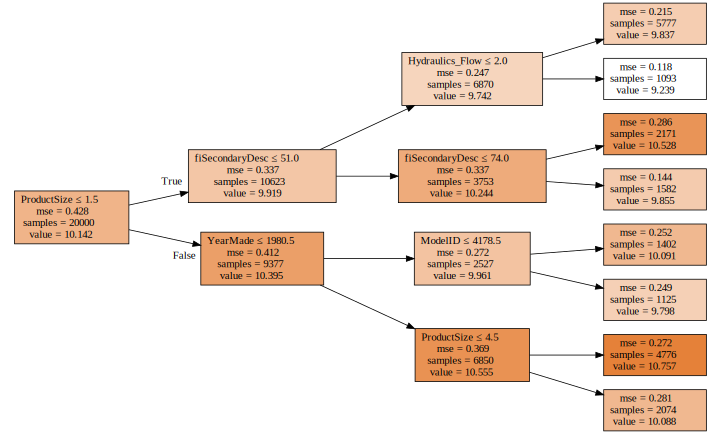

In [43]:
# import the export_graphviz exporter 
from sklearn.tree import export_graphviz

# import draw_tree method
from fastai.structured import draw_tree

# draw a random forest
draw_tree(m.estimators_[0], X_train, precision=3)

A tree consist of a **sequence of binary decisions** or splits.
- Each step **partitions the data** into two subsets.
- Each split point is a decision to split the data on a **particular variable** (feature) and in a **particular location** (value).
- **All possible split points are evaluated** (all features and values).
- The very **best split point is chosen** each time trying to **minimize the error** (for regression).
- The error is calculated by **comparing the predicted values with the known values** of the subsets of a particular split point.

Each box in the graphic that represents a split point consists of:
- A **variable** and a **value** to split on.
- **MSE** quantifies the error, the lower the better.
- **Samples** is the size (rows) of the subset.
- The **average** of the **target** value (log of price) of the subset.

Sources: [1](https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/), [2](https://infocenter.informationbuilders.com/wf80/index.jsp?topic=%2Fpubdocs%2FRStat16%2Fsource%2Ftopic47.htm).

Looking at our little tree, we can see that we **start with 20,000 rows** (the root node),  **split only three times** (trying to minimze the MSE) and end up with **many subsets of different sizes** (leaf nodes), which are the result of the last split.

If we create the largest (**deepest**) tree possible, it'll **keep splitting until each leaf node has only one sample**. Such tree would learn all there is to learn about the training data but would be a model that would **not be able to generalize a pattern** from it. And that is exactly what overfitting is: to **learn the noise instead of the signal**. Let's see it in practice.

In [44]:
# remove the max_depth parameter (by default to None) so the nodes expanded until they can't do it anymore. 
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)

m.fit(X_train, y_train)

# [RMSE of the training set, RMSE of the validation set, R Squared of the training set, R Squared of the validation set]
print_scores(m)

[6.153480596427405e-17, 0.5932594504322316, 1.0, 0.37145365657694]


The scores are **great in the training set**: the RMSE is 4.3511679e-17 (that is a 0 followed by a lot of zeroes) and the R Squared is 1 (the best possible score). This is because we can in fact **predict everything** from the training data.

Our interest, of course, is to do **better in the validation set** to get more generalizable results and for that we need to use **multiple trees** and some kind of **model averaging approach** .

## Bagging

### Intro to bagging

Bootstrap aggregating (**Bagging**) is a way of doing repeated statistical analyses on the 
same data and combining them to form a single result.
- The predictions that are combined are all different thanks to the use of **resampling** (bootsrap samples).
- **Bootstraping** is a way of generating random non-repeated samples from a dataset.

A **random forest** is simply a way of **bagging trees**.
- It combines the **unique predictions** of different trees.
- Each tree is trained on a **randomly generated training set**.
- It grows **deep trees** that overfit their individual non-repeated subsets.
- The prediction **error** of the trees are **random** so the **average of the predictions doesn't overfit**.

Sources: [1](https://onlinecourses.science.psu.edu/stat857/node/181/), [2](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/).

To learn about bagging in random forests, let's look at our **base model** again.

In [45]:
# the number of trees in the forest by default is 10.
m = RandomForestRegressor(n_jobs=-1)

m.fit(X_train, y_train)

# [RMSE of the training set, RMSE of the validation set, R Squared of the training set, R Squared of the validation set]
print_scores(m)

[0.11199114404348318, 0.42210340279722086, 0.9707276867956796, 0.6818106199353584]


We'll grab the **predictions for each individual tree**, and look at one example.

In [46]:
# use a list comprehension to loop through the random forest and concatenates the predictions of each individual tree on a new axis
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

# dimensions of the predictions (rows, columns)
preds.shape

(10, 12000)

There are 10 sets of predictions (trees) with 12,000 values (predictions), which corresponds to the size of the validation set.
- Let's see what the **first prediction of each tree** does look like and how they **compare** with the actual value **when averaged out**.

In [47]:
# print the first prediction for each of the ten trees [all tree rows, first prediction column]
print(preds[:,0])

# print the mean of the first ten predictions
print(np.mean(preds[:,0]))

# the first value of the validation set
y_valid[0]

[ 9.4727  11.15625 10.81978  9.04782 11.15625  9.3501  11.15625 11.15625 11.15625  9.51044]
10.398210424726772


9.104979856318357

None of the individual trees have very good predictions but **the mean of them is actually good enough**.

### Out-of-bag (OOB) score

Out-of-bag (**OOB**) **error**  is another method of measuring the **prediction performance** of models utilizing **bagging**.
- Out-of-bag samples are **samples not used** during training for **any given tree**.
- For **every tree** in the forest there is **unseen data** available to make **new predictions** on.
- For each **training sample**, calculates the **mean prediction error** using only the trees that were not trained on that sample.
- **Evaluates** the model on the training set **without** needing a separate **validation set**.

Sources: [1](https://en.wikipedia.org/wiki/Out-of-bag_error), [2](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html), [3](https://stackoverflow.com/questions/18541923/what-is-out-of-bag-error-in-random-forests).

This also has the benefit of allowing us to **assess** whether **our model generalizes** even if we **only have** a **small amount of data** so want to avoid separating some out to create a validation set.

We can add one more parameter to our model, **`oob_score`**, to use out-of-bag samples to estimate the **R^2** on unseen data.
- There is **minimum number of trees** to be used for any given data that are **necessary** to compute a reliable OOB error (or **sklearn warns** us).
- We'll also update the `print_scores` function to **print** the  **OOB error** last.

In [48]:
# appends the oob score to the list of scores if the model has the parameter
def print_scores(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Because we use too few trees we get a UserWarning and an unreliable oob score
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

print('10 trees:')
# [RMSE of the training set, RMSE of the validation set, R Squared of the training set, R Squared of the validation set, OOB score]
print_scores(m)

# 30 trees
m = RandomForestRegressor(n_estimators=30, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

print('\n30 trees:')
# [RMSE of the training set, RMSE of the validation set, R Squared of the training set, R Squared of the validation set, OOB score]
print_scores(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 trees:
[0.11357318786461638, 0.4123216061481111, 0.9698948141160931, 0.6963871420619733, -1.5075611762871182]

30 trees:
[0.0989666559750044, 0.40745515878275357, 0.9771404607394432, 0.7035116620518651, 0.8390675653968274]


The **OOB** is **better** than the **R Squared** of the validation set because the validation set is a **different time period** entirely, while the OOB is calculated on random samples of the same time period as the training set.
- In this case the **validation set is much harder to predict** and the R Squared will consistently be lower than the OOB.

## Hyperparameter tuning

### Subsampling

Earlier we used **subsampling** to speed up the analysis, which basically consist in **limiting** the total **amount of data** that our **model can access** so it **trains faster**. There is a **better way** to do it that is actually **also** one of the easiest ways to **avoid overfitting**.
- Rather than use **one random subset** of the data for our **entire model** (and for all its trees), we'll use a **different random subset per tree**.
- **Given enough trees**, and enough random subsets, the model will **eventually** be able to **train with** much of **all the available data**.
- Each **individual tree** it'll be **just as fast** as if we were **using one subset** for all the trees, **like** we did **before**.

We'll use a method from the **fastai library** , **`set_rf_samples`**, to do just that.
- From the documentation: "**changes Scikit learn's random forests** to give each tree a random sample of n random rows".
- It is **not compatible** with **OOB score** right now, so will simply do without it.
- To turn off `set_rf_samples` to use random forest in the normal way, it's necessary to call **`reset_rf_samples`**.

First we must **return** to using our **full dataset** so the **subsampling** is done on the **entire data**.

In [0]:
X, y, nas_dict = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(X, split_point)
y_train, y_valid = split_vals(y, split_point)

We'll use the same subset size as before: **20,000** random samples, but this time will be a different subset for each tree.

In [0]:
# import set_rf_samples
from fastai.structured import set_rf_samples

set_rf_samples(20000)

In [51]:
# 10 trees
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_scores(m)

CPU times: user 8.16 s, sys: 232 ms, total: 8.39 s
Wall time: 4.96 s
[0.24053776252482853, 0.27773852454853754, 0.8790791030949857, 0.8622409237105992]


Since each additional tree allows the model to see more data, this approach can make **additional trees more useful without needing additional fine-tuning**.

In [52]:
# 40 trees
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
%time m.fit(X_train, y_train)
print_scores(m)

CPU times: user 28.3 s, sys: 110 ms, total: 28.4 s
Wall time: 15.1 s
[0.22755739960942428, 0.264524656380663, 0.8917777022284106, 0.8750373311884152]


### Number of trees

We'll create a graphic to see what happens to the **R Squared** when using **1 tree up to 100 trees**.
- We'll **store** the **predictions** of each tree in a **numpy array** like we did before for our base model.
- We'll **loop** through the **predictions** of each tree to **plot the change** in **R Squared** as we add more trees.

In [53]:
# 100 trees
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
%time m.fit(X_train, y_train)
print_scores(m)

# use a list comprehension to loop through the random forest and concatenates the predictions of each individual tree on a new axis
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

# dimensions of the predictions (rows, columns)
preds.shape

CPU times: user 1min 14s, sys: 183 ms, total: 1min 14s
Wall time: 38.5 s
[0.22482420316613763, 0.25961372148628303, 0.8943618099152297, 0.8796341576734357]


(100, 12000)

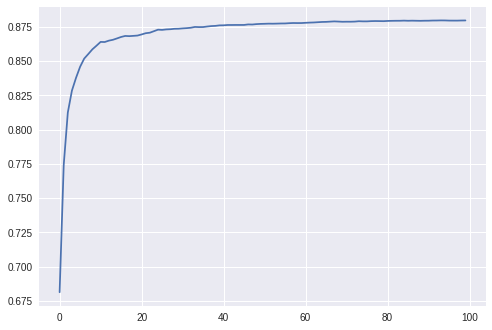

In [54]:
# import matplotlib
import matplotlib.pyplot as plt

# import metrics module
from sklearn import metrics

# plot the calculated r^2 of the true values and the predicted values up to [:i] trees (looping through a range from 1 to 100). 
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(100)]);

The shape of this curve clearly shows that the **model improves** the **more trees** we use, but it also suggests that adding more trees is beneficial **up to a point**, because it **flattens out** the closer it gets to 100 trees.
- There is **no lineal relationship** between number of trees and our evaluation metric score.
- The **number of trees** we use can **vary wether** we are:
 - **developing the model**, we'll propably use less trees but do lots of iterations, or
 - **finishing the model**, in that case, we'll probably use as much trees as our processor can handle to fit the model with all the available data and using the best found parameters.
- **Without** our **subsampling** approach, building **lots of trees** on **lots of data** can be computationally expensive and very **time comsuming**.

### Depth of the trees

Another way to reduce over-fitting is to grow our trees **less deeply**.
- We can do this with **`min_samples_leaf`** parameter, which requires some minimum number of rows in every leaf node (by default 1).
- For each tree there will be less levels and **less decisions** being made so it will result in simpler models.
- The predictions are made by **averaging more samples** in the leaf node.
- We can expect the trees to be less powerful on its own but to **generalize better**.

Possible good values to try:
- 1, 3, 5, 10, 25, 100

In [55]:
# baseline to compare to

# 40 trees - 1 minimum samples per leaf (default)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
%time m.fit(X_train, y_train)
print_scores(m)

CPU times: user 29.6 s, sys: 122 ms, total: 29.8 s
Wall time: 15.9 s
[0.22668994748062743, 0.2615928731808179, 0.8926012195584211, 0.8777919569073176]


In [56]:
# 2 minimum samples per leaf
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, n_jobs=-1)
%time m.fit(X_train, y_train)
print_scores(m)

CPU times: user 26.3 s, sys: 115 ms, total: 26.4 s
Wall time: 14.1 s
[0.2289739627309157, 0.26165293803363254, 0.8904261234162655, 0.8777358296072532]


### Variance

Another way to reduce over-fitting is to increase the amount of **variation amongst the trees**.
- We can do this by specifying **`max_features`**, which is the **number of features** to consider at **each split**.
- This way not only randomly selects a **sample of rows** for each tree, but **also** randomly selects a **sample of columns** for each split.


Possible good values to try:
- None: use all columns.
- 0.5: use half of the columns
- 'sqrt' (default): use the square root of total number of columns.

In [57]:
# consider all columns per split
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features=None, n_jobs=-1)
m.fit(X_train, y_train)
print_scores(m)

[0.22894548444083573, 0.26089241928195683, 0.8904533778914298, 0.8784455411916764]


### Experimenting

You can revert to using a full bootstrap sample in order to experiment with these hyperparameters further and to see their full impact.
- Just remember the models will **train much slower**.
- For more information, you can check this post on stackoverflow: [Practical questions on tuning Random Forests](https://stats.stackexchange.com/questions/53240/practical-questions-on-tuning-random-forests).

In [0]:
# import reset_rf_samples
from fastai.structured import reset_rf_samples

reset_rf_samples()

In [59]:
# 3 minimum samples per leaf
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_scores(m)

CPU times: user 5min 8s, sys: 382 ms, total: 5min 8s
Wall time: 2min 39s
[0.11494012723145729, 0.23278629006077614, 0.9723892519408875, 0.9032250909276806, 0.9084255292742461]


In [60]:
# half columns per split
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_scores(m)

CPU times: user 2min 34s, sys: 334 ms, total: 2min 34s
Wall time: 1min 21s
[0.11910699600618097, 0.22803480187416636, 0.9703510464973758, 0.9071353900142711, 0.9117261940760485]
